In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_validate,cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, mean_squared_error, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import brier_score_loss

from imblearn.metrics import classification_report_imbalanced

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier

import xgboost as xgb
from xgboost import XGBClassifier



In [2]:
monkeypox = pd.read_csv('Monkeypox.csv')
monkeypox.head()

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,P0,None,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive
3,P3,None,True,False,False,False,True,True,True,False,Positive
4,P4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive


## Cleaning dataset

#### Checking what kind of data we have

In [3]:
monkeypox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Patient_ID                      25000 non-null  object
 1   Systemic Illness                25000 non-null  object
 2   Rectal Pain                     25000 non-null  bool  
 3   Sore Throat                     25000 non-null  bool  
 4   Penile Oedema                   25000 non-null  bool  
 5   Oral Lesions                    25000 non-null  bool  
 6   Solitary Lesion                 25000 non-null  bool  
 7   Swollen Tonsils                 25000 non-null  bool  
 8   HIV Infection                   25000 non-null  bool  
 9   Sexually Transmitted Infection  25000 non-null  bool  
 10  MonkeyPox                       25000 non-null  object
dtypes: bool(8), object(3)
memory usage: 781.4+ KB


In [4]:
monkeypox.describe()

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
count,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000
unique,25000,4,2,2,2,2,2,2,2,2,2
top,P0,Fever,False,True,True,False,True,True,True,False,Positive
freq,1,6382,12655,12554,12612,12514,12527,12533,12584,12554,15909


#### Lowercase column names and data and replace " " with "_"

In [5]:
monkeypox.columns = monkeypox.columns.str.lower().str.replace(" ", "_")

In [6]:
objColumns = monkeypox.select_dtypes(object).columns
boolColumns = monkeypox.select_dtypes(bool).columns

for col in objColumns:
    monkeypox[col] = monkeypox[col].str.lower().str.replace(" ", "_")

monkeypox.head()

,patient_id,systemic_illness,rectal_pain,sore_throat,penile_oedema,oral_lesions,solitary_lesion,swollen_tonsils,hiv_infection,sexually_transmitted_infection,monkeypox
0,p0,none,False,True,True,True,False,True,False,False,negative
1,p1,fever,True,False,True,True,False,False,True,False,positive
2,p2,fever,False,True,True,False,False,False,True,False,positive
3,p3,none,True,False,False,False,True,True,True,False,positive
4,p4,swollen_lymph_nodes,True,True,True,False,False,True,True,False,positive


In [7]:
objColumns

Index(['patient_id', 'systemic_illness', 'monkeypox'], dtype='object')

In [8]:
df = monkeypox.copy()

#### Converting data to 1's and 0's

In [9]:
ordEncoder = OrdinalEncoder()
df["systemic_illness_ord"] = ordEncoder.fit_transform(df[["systemic_illness"]])
df["monkeypox_ord"] = ordEncoder.fit_transform(df[["monkeypox"]])
df[boolColumns] = df[boolColumns].astype(int)
df.head()

,patient_id,systemic_illness,rectal_pain,sore_throat,penile_oedema,oral_lesions,solitary_lesion,swollen_tonsils,hiv_infection,sexually_transmitted_infection,monkeypox,systemic_illness_ord,monkeypox_ord
0,p0,none,0,1,1,1,0,1,0,0,negative,2.0,0.0
1,p1,fever,1,0,1,1,0,0,1,0,positive,0.0,1.0
2,p2,fever,0,1,1,0,0,0,1,0,positive,0.0,1.0
3,p3,none,1,0,0,0,1,1,1,0,positive,2.0,1.0
4,p4,swollen_lymph_nodes,1,1,1,0,0,1,1,0,positive,3.0,1.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      25000 non-null  object 
 1   systemic_illness                25000 non-null  object 
 2   rectal_pain                     25000 non-null  int32  
 3   sore_throat                     25000 non-null  int32  
 4   penile_oedema                   25000 non-null  int32  
 5   oral_lesions                    25000 non-null  int32  
 6   solitary_lesion                 25000 non-null  int32  
 7   swollen_tonsils                 25000 non-null  int32  
 8   hiv_infection                   25000 non-null  int32  
 9   sexually_transmitted_infection  25000 non-null  int32  
 10  monkeypox                       25000 non-null  object 
 11  systemic_illness_ord            25000 non-null  float64
 12  monkeypox_ord                   

## EDA

#### Checking missing values

In [11]:
monkeypox.isnull().sum()

patient_id                        0
systemic_illness                  0
rectal_pain                       0
sore_throat                       0
penile_oedema                     0
oral_lesions                      0
solitary_lesion                   0
swollen_tonsils                   0
hiv_infection                     0
sexually_transmitted_infection    0
monkeypox                         0
dtype: int64

Zero missing values

#### Checking feature values distribution.  The target class "monkeypox" is imbalanced.

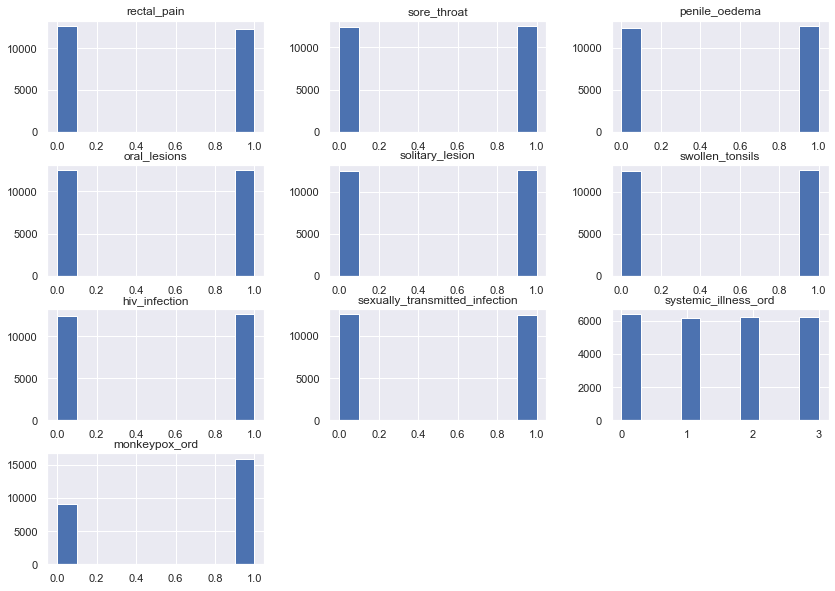

In [12]:
_ = df.hist(figsize=(14,10))

#### Let's check the correlation

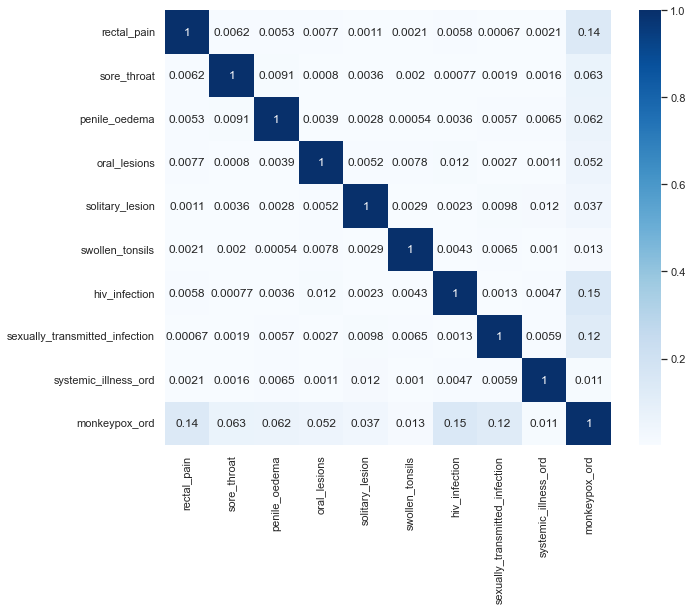

In [13]:
correlation = df.corr().abs()
plt.figure(figsize=(10,8))
_ = sns.heatmap(correlation, cmap="Blues", annot=True)

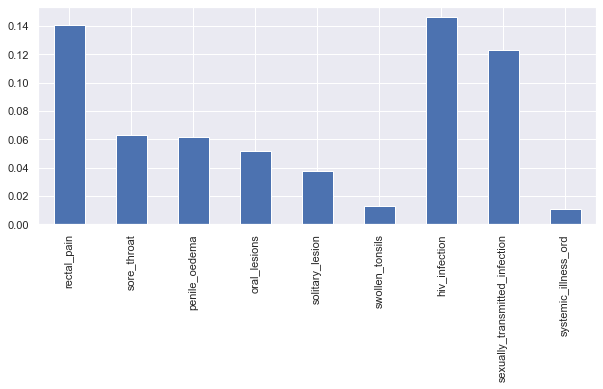

In [14]:
correlation = df.drop(columns='monkeypox_ord').corrwith(df.monkeypox_ord).abs()
plt.figure(figsize=(10,4))
_ = correlation.plot(kind='bar', grid=True)

Some features seem not to be correlated with the target.  In thiscase we will leave all the features to analize influence of all of them.

Let's remove the columns we added for EDA analysis

In [15]:
df.drop(columns=['systemic_illness', 'monkeypox'], inplace=True)

In [72]:
df.drop(columns=['patient_id'], inplace=True)

## Data Processing

Helper function to split dataset

In [73]:
def splitDF(df):    
    
    random_state = 42
    target = df.monkeypox_ord    
    data = df.drop(columns = ['monkeypox_ord'])
    
    dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, 
                                                              target,
                                                              test_size = 0.2,
                                                              random_state = random_state)
    
    dfTrain, dfVal, yTrain, yVal = train_test_split(dfTrainFull,
                                                    yTrainFull,
                                                    test_size = 0.25,
                                                    random_state = random_state)
    print(f'The dataset has been split in: '
          f'Training set {len(yTrain)} samples, '
          f'Validation: {len(yVal)} samples'
          f' and Test set: {len(yTest)} samples')
    
    return dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest

In [74]:
dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest = splitDF(df)

The dataset has been split in: Training set 15000 samples, Validation: 5000 samples and Test set: 5000 samples


#### Preprocessing

In [76]:
categColumns = ['systemic_illness_ord']
allColumns = list(dfTrain.columns)

In [77]:
# creating preprocesors
categPreprocessor = OneHotEncoder(handle_unknown="ignore")

# Transforming the data
preprocessor = ColumnTransformer([('one-hot-encoder', categPreprocessor, categColumns)],
                                 remainder="passthrough")

    #('one-hot-encoder', catPreprocessor, categoricalCols),('standard_scaler', numPreprocessor, numericalCols)])
    #], remainder="passthrough")


## Training Models

#### Logistic Regression

In [78]:
#model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))    
model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight='balanced'))

#model.fit(dfTrain[0:size], yTrain[0:size])
model.fit(dfTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['systemic_illness_ord'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [79]:
yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
auc = roc_auc_score(yVal, yValPredProba)

yTestpred=model.predict_proba(dfTest)[:,1]

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
auc = roc_auc_score(yTrain, yTrainPredProba)

print(f'Val AUC: {auc}')
print(f'Train AUC: {auc}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}\n')

print(classification_report(yVal, yValPred))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val AUC: 0.7000668116260674
Train AUC: 0.7000668116260674
Test AUC: 0.7073457130993958

              precision    recall  f1-score   support

         0.0       0.50      0.64      0.57      1873
         1.0       0.74      0.62      0.68      3127

    accuracy                           0.63      5000
   macro avg       0.62      0.63      0.62      5000
weighted avg       0.65      0.63      0.63      5000

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.50      0.64      0.62      0.57      0.63      0.40      1873
        1.0       0.74      0.62      0.64      0.68      0.63      0.40      3127

avg / total       0.65      0.63      0.64      0.63      0.63      0.40      5000



In [80]:
steps = [ preprocessor, ('model', LogisticRegression(max_iter=1000,class_weight='balanced'))]
#StandardScaler().fit(dfTrainFull)
#pipeline = make_pipeline(StandardScaler(), LogisticRegression())
Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
scores = pd.DataFrame.from_dict( cross_validate(model, dfTrain, yTrain, cv=cv,
                         scoring=('f1', 'f1_weighted',  'recall' , 'precision', 'accuracy', 'roc_auc'),
                         return_train_score=True))
                                
scores

,fit_time,score_time,test_f1,train_f1,test_f1_weighted,train_f1_weighted,test_recall,train_recall,test_precision,train_precision,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.019998,0.019001,0.681147,0.691912,0.639824,0.647131,0.616675,0.634683,0.760673,0.760484,0.633000,0.640667,0.698137,0.700322
1,0.019001,0.012002,0.702456,0.687370,0.658885,0.642502,0.644992,0.629571,0.771160,0.756855,0.652667,0.635917,0.710099,0.697382
2,0.025000,0.012004,0.690129,0.691670,0.645511,0.646800,0.632407,0.634552,0.759446,0.760088,0.639000,0.640333,0.705101,0.698661
3,0.022995,0.018003,0.681779,0.694863,0.637063,0.650485,0.622968,0.637436,0.752852,0.763662,0.630333,0.644083,0.682779,0.704215
4,0.019003,0.011996,0.698017,0.691559,0.650844,0.647148,0.645702,0.633718,0.759556,0.761020,0.644667,0.640667,0.699486,0.700029
5,0.020000,0.011999,0.693539,0.688306,0.649092,0.644086,0.636078,0.629571,0.762414,0.759128,0.642667,0.637500,0.701739,0.699570
6,0.022001,0.013999,0.701336,0.690517,0.655810,0.645317,0.647090,0.633766,0.765509,0.758431,0.649667,0.638833,0.709126,0.697580
7,0.026998,0.011999,0.687177,0.687841,0.643974,0.644633,0.626639,0.627343,0.760662,0.761253,0.637333,0.638000,0.699291,0.700202
8,0.024999,0.013002,0.678889,0.696334,0.633099,0.651505,0.621395,0.639927,0.748106,0.763648,0.626333,0.645167,0.677306,0.705627
9,0.034000,0.014997,0.692594,0.693721,0.648157,0.647848,0.634696,0.638700,0.762115,0.759115,0.641667,0.641500,0.708428,0.697777


In [81]:
scoresx = scores.mean(axis=0)     
scoresx

fit_time             0.023400
score_time           0.013900
test_f1              0.690706
train_f1             0.691409
test_f1_weighted     0.646226
train_f1_weighted    0.646745
test_recall          0.632864
train_recall         0.633927
test_precision       0.760249
train_precision      0.760368
test_accuracy        0.639733
train_accuracy       0.640267
test_roc_auc         0.699149
train_roc_auc        0.700137
dtype: float64

In [82]:
model = Pipeline([("classifier", LogisticRegression(max_iter=1000,class_weight='balanced'))])

param_grid = {
    'classifier__C': (1e-3, 1e-2, 0.05, 0.1, 0.05, 1),
    #'classifier__max_leaf_nodes': (1, 5,10,15,20),
    #'classifier__max_features': (1,3,5,7,10)
}
scoring = {"AUC": "roc_auc", "f1_weighted": "f1_weighted"}

cv = StratifiedKFold(n_splits=3)
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 #scoring=scoring,
                                 #scoring="f1_weighted",
                                 scoring="roc_auc",
                                 n_jobs=2,
                                 cv=cv,
                                 return_train_score=True,)
                                 #refit=False)
model_grid_search.fit(dfTrain, yTrain)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=2,
             param_grid={'classifier__C': (0.001, 0.01, 0.05, 0.1, 0.05, 1)},
             return_train_score=True, scoring='roc_auc')

In [83]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
#cv_results
res = cv_results[[
    "param_classifier__C",
    "mean_test_score",
    'std_test_score',
    'rank_test_score'
    #"mean_train_AUC",
    #"std_train_AUC",
    #"rank_test_AUC",
    #"mean_train_f1_weighted",
    #"std_train_f1_weighted",
    #"rank_test_f1_weighted"
]]
res.sort_values(by=['rank_test_score']).head(10)

,param_classifier__C,mean_test_score,std_test_score,rank_test_score
1,0.01,0.653478,0.003829,1
3,0.1,0.653476,0.003891,2
2,0.05,0.653473,0.003878,3
4,0.05,0.653473,0.003878,3
5,1,0.653472,0.003885,5
0,0.001,0.652801,0.002882,6


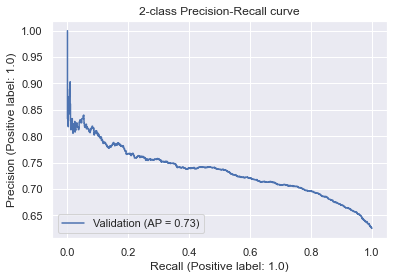

In [84]:
display = PrecisionRecallDisplay.from_estimator(
    model_grid_search, dfVal, yVal, name="Validation", 
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

#### DecisionTreeClassifier

In [85]:
# creating the model
from sklearn.pipeline import make_pipeline
model = make_pipeline(DecisionTreeClassifier(max_depth=7,
                                             max_leaf_nodes=25,
                                             class_weight='balanced',
                                             max_features=9,
                                             random_state=1))

model.fit(dfTrain, yTrain)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                                        max_features=9, max_leaf_nodes=25,
                                        random_state=1))])

In [112]:
yValPred = model.predict_proba(dfVal)[:,1]
auc = roc_auc_score(yVal, yValPred)
print(f'Val AUC: {auc}, Val Brier: {brier}')
brier = brier_score_loss(yVal, yValPred)

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}, Val Brier: {brier}')
brier = brier_score_loss(yTest, yTestpred)

yTrainPred = model.predict_proba(dfTrain)[:,1]
auc = roc_auc_score(yTrain, yTrainPred)
print(f'Train AUC: {auc}, Val Brier: {brier}\n')
brier = brier_score_loss(yTrain, yTrainPred)


#print(classification_report(yVal, model.predict(dfVal)))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val AUC: 0.6866216619761645, Val Brier: 0.21955652530002942
Test AUC: 0.6951478216150252, Val Brier: 0.22160561919549676
Train AUC: 0.6920493589216052, Val Brier: 0.21926579855146305

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.51      0.64      0.63      0.57      0.63      0.40      1873
        1.0       0.74      0.63      0.64      0.68      0.63      0.40      3127

avg / total       0.66      0.63      0.64      0.64      0.63      0.40      5000



In [97]:
cv = StratifiedKFold(n_splits=5)
cv_results = cross_validate(model, dfTrain, yTrain,cv=cv,
                            scoring=['roc_auc', 'average_precision',
                                     'recall','f1_weighted', 'accuracy',
                                     'balanced_accuracy','neg_brier_score' ])
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_roc_auc,test_average_precision,test_recall,test_f1_weighted,test_accuracy,test_balanced_accuracy,test_neg_brier_score
0,0.010000,0.011011,0.674929,0.752024,0.604615,0.629722,0.622667,0.629389,-0.223382
1,0.009986,0.015005,0.676217,0.757414,0.656529,0.643872,0.638333,0.631558,-0.224213
2,0.009992,0.011019,0.708404,0.779304,0.605139,0.644447,0.637667,0.649779,-0.215926
3,0.010005,0.012996,0.685184,0.763452,0.667016,0.648413,0.643333,0.634515,-0.220060
4,0.010998,0.011002,0.679997,0.753742,0.650419,0.643877,0.638000,0.633360,-0.224678


In [98]:
dfTrain.columns

Index(['rectal_pain', 'sore_throat', 'penile_oedema', 'oral_lesions',
       'solitary_lesion', 'swollen_tonsils', 'hiv_infection',
       'sexually_transmitted_infection', 'systemic_illness_ord'],
      dtype='object')

In [117]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced', random_state=1))])
param_grid = {
    'classifier__max_depth': (1,3,5,7,10),
    'classifier__max_leaf_nodes': (1, 5,10,15,20),
    'classifier__max_features': (1,3,5,7,10)
}
scoring = {"AUC": "roc_auc"}#, "f1_weighted": "f1_weighted"}

cv = StratifiedKFold(n_splits=3)
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 #scoring=scoring,
                                 #scoring="f1_weighted",
                                 #scoring="neg_brier_score",
                                 scoring="roc_auc",
                                 n_jobs=2,
                                 cv=cv,
                                 return_train_score=True,)
                                 #refit=False)
model_grid_search.fit(dfTrain, yTrain)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=1))]),
             n_jobs=2,
             param_grid={'classifier__max_depth': (1, 3, 5, 7, 10),
                         'classifier__max_features': (1, 3, 5, 7, 10),
                         'classifier__max_leaf_nodes': (1, 5, 10, 15, 20)},
             return_train_score=True, scoring='roc_auc')

In [118]:
print(model_grid_search.cv_results_.keys())

cv_results = pd.DataFrame(model_grid_search.cv_results_)
#cv_results
res = cv_results[[
    "param_classifier__max_depth",
    'param_classifier__max_leaf_nodes',
    "param_classifier__max_features",
    "mean_test_score",'std_test_score', 'rank_test_score'
    #"mean_train_AUC",
    #"std_train_AUC",
    #"rank_test_AUC",
    #"mean_train_f1_weighted",
    #"std_train_f1_weighted",
    #"rank_test_f1_weighted"
]]

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier__max_depth', 'param_classifier__max_features', 'param_classifier__max_leaf_nodes', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


In [119]:
res.sort_values(by='rank_test_score').head(10)

,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features,mean_test_score,std_test_score,rank_test_score
74,5,20,10,0.69,0.01,1
69,5,20,7,0.69,0.01,2
114,10,20,5,0.69,0.01,3
89,7,20,5,0.69,0.01,3
119,10,20,7,0.68,0.01,5
94,7,20,7,0.68,0.01,5
124,10,20,10,0.68,0.01,7
99,7,20,10,0.68,0.01,7
64,5,20,5,0.68,0.01,9
68,5,15,7,0.68,0.01,10


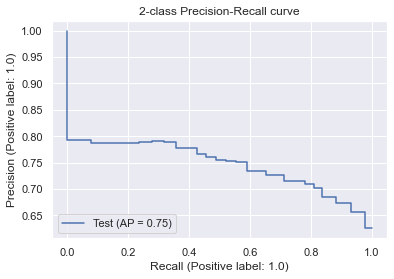

In [120]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model_grid_search, dfVal, yVal, name="Test", 
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [121]:
model_grid_search.best_params_

{'classifier__max_depth': 5,
 'classifier__max_features': 10,
 'classifier__max_leaf_nodes': 20}

In [126]:
model = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced',
                                                        max_depth=5,
                                                        max_features=10,
                                                        max_leaf_nodes=20))])

model.fit(dfTrainFull, yTrainFull)

yValPred = model.predict_proba(dfVal)[:,1]
auc = roc_auc_score(yVal, yValPred)
print(f'Val AUC: {auc}, Val Brier: {brier}')
brier = brier_score_loss(yVal, yValPred)

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}, Val Brier: {brier}')
brier = brier_score_loss(yTest, yTestpred)

yTrainPred = model.predict_proba(dfTrain)[:,1]
auc = roc_auc_score(yTrain, yTrainPred)
print(f'Train AUC: {auc}, Val Brier: {brier}\n')
brier = brier_score_loss(yTrain, yTrainPred)


#print(classification_report(yVal, model.predict(dfVal)))
print(classification_report(yTest, model.predict(dfTest)))
print(classification_report_imbalanced(yTest, model.predict(dfTest)))

Val AUC: 0.6855863822167161, Val Brier: 0.22066931038570953
Test AUC: 0.6922379161862929, Val Brier: 0.2216044173621709
Train AUC: 0.6875926403880924, Val Brier: 0.21977332282721473

              precision    recall  f1-score   support

         0.0       0.49      0.63      0.55      1754
         1.0       0.76      0.64      0.70      3246

    accuracy                           0.64      5000
   macro avg       0.62      0.64      0.62      5000
weighted avg       0.67      0.64      0.65      5000

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.49      0.63      0.64      0.55      0.64      0.40      1754
        1.0       0.76      0.64      0.63      0.70      0.64      0.40      3246

avg / total       0.67      0.64      0.63      0.65      0.64      0.40      5000



In [129]:
cv = StratifiedKFold(n_splits=5)
cv_results = cross_validate(
    model_grid_search, dfTrainFull, yTrainFull, cv=cv, n_jobs=-1, return_estimator=True
)
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.683 ± 0.009


In [130]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__max_depth': 7, 'classifier__max_features': 5, 'classifier__max_leaf_nodes': 20}
Best hyperparameters for fold #2:
{'classifier__max_depth': 5, 'classifier__max_features': 10, 'classifier__max_leaf_nodes': 20}
Best hyperparameters for fold #3:
{'classifier__max_depth': 5, 'classifier__max_features': 10, 'classifier__max_leaf_nodes': 20}
Best hyperparameters for fold #4:
{'classifier__max_depth': 5, 'classifier__max_features': 7, 'classifier__max_leaf_nodes': 20}
Best hyperparameters for fold #5:
{'classifier__max_depth': 5, 'classifier__max_features': 7, 'classifier__max_leaf_nodes': 20}


In [134]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
cv_results = cross_validate(tree, dfTrainFull, yTrainFull, n_jobs=2)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

R2 score obtained by cross-validation: 0.065 ± 0.013


In [139]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    "max_depth": [5, 8, None],
    "min_samples_split": [2, 10, 30, 50],
    "min_samples_leaf": [0.01, 0.05, 0.1, 1]}

#cv = StratifiedKFold(n_splits=3)
cv = 3

tree = GridSearchCV(DecisionTreeRegressor(),
                    param_grid=param_grid, cv=cv, n_jobs=2)
cv_results = cross_validate(tree, dfTrainFull, yTrainFull, scoring="roc_auc", n_jobs=-1,
                            return_estimator=True)
scores = cv_results["test_score"]

print(f"AUC score obtained by cross-validation: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

AUC score obtained by cross-validation: 0.685 ± 0.009
Wall time: 1.5 s


#### Random Forest

In [142]:
model = make_pipeline(RandomForestClassifier(n_estimators=10,
                                             random_state=1,
                                             max_depth=6,
                                             max_features=7,
                                             class_weight='balanced'))
model.fit(dfTrain, yTrain)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        max_features=7, n_estimators=10,
                                        random_state=1))])

In [144]:
#yValPred = RF.predict_proba(dfVal)[:,1]

#roc_auc_score(yVal, yValPred)

yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train AUC: {auc}')



print(classification_report(yVal, model.predict(dfVal)))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val AUC: 0.6896703888475604
Test AUC: 0.7013449936804952
Train AUC: 0.6896703888475604
              precision    recall  f1-score   support

         0.0       0.52      0.61      0.56      1873
         1.0       0.74      0.66      0.70      3127

    accuracy                           0.64      5000
   macro avg       0.63      0.64      0.63      5000
weighted avg       0.66      0.64      0.65      5000

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.52      0.61      0.66      0.56      0.64      0.40      1873
        1.0       0.74      0.66      0.61      0.70      0.64      0.41      3127

avg / total       0.66      0.64      0.63      0.65      0.64      0.40      5000



#### AdaBoostClassifier

In [170]:
model = make_pipeline(preprocessor, AdaBoostClassifier())

model.fit(dfTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['systemic_illness_ord'])])),
                ('adaboostclassifier', AdaBoostClassifier())])

In [173]:
yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
print(f'Train AUC: {auc}\n')

print(classification_report(yVal, model.predict(dfVal), ))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val AUC: 0.6936688549227052
Test AUC: 0.7073393900817144
Train AUC: 0.6936688549227052

              precision    recall  f1-score   support

         0.0       0.62      0.38      0.47      1873
         1.0       0.70      0.86      0.77      3127

    accuracy                           0.68      5000
   macro avg       0.66      0.62      0.62      5000
weighted avg       0.67      0.68      0.66      5000

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.62      0.38      0.86      0.47      0.57      0.31      1873
        1.0       0.70      0.86      0.38      0.77      0.57      0.35      3127

avg / total       0.67      0.68      0.56      0.66      0.57      0.33      5000



#### XGBoost

In [178]:
dTrain = xgb.DMatrix(dfTrain, yTrain)#, enable_categorical=True)
dVal = xgb.DMatrix(dfVal, yVal)#, enable_categorical=True)
dTest = xgb.DMatrix(dfTest, yTest)#, enable_categorical=True)
xgbParams = {
'eta': 0.05,
'max_depth': 10,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthreads': 8,

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgbParams, dTrain, num_boost_round=10, )

yValPred = model.predict(dVal)

print(f'Val AUC: {roc_auc_score(yVal,yValPred)}')

yTestpred = model.predict(dTest)
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPred = model.predict(dTrain)
print(f'Train AUC: {roc_auc_score(yTrain,yTrainPred)}\n')

print(classification_report(yVal, (yValPred > 0.5).astype(int)))
print(classification_report_imbalanced(yVal, (yValPred > 0.5).astype(int)))

[23:48:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "nthreads" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Val AUC: 0.6703835546318162
Test AUC: 0.6823473114177541
Train AUC: 0.7347568945022698

              precision    recall  f1-score   support

         0.0       0.58      0.40      0.47      1873
         1.0       0.70      0.83      0.76      3127

    accuracy                           0.67      5000
   macro avg       0.64      0.61      0.61      5000
weighted avg       0.65      0.67      0.65      5000

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.58      0.40      0.83      0.47      0.57      0.31      1873
 

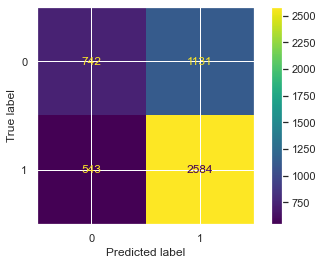

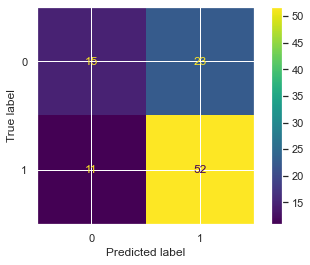

In [179]:
cm = confusion_matrix(yVal, (yValPred > 0.5).astype(int))
cmprob = np.round(100 * cm / len(yVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()

In [180]:
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_validate (model, dfTrain, yTrain, scoring=['roc_auc','f1_weighted'], cv=cv, n_jobs=-1)

In [188]:
# summarize performance
print('Mean ROC AUC: %.5f' % scores['test_roc_auc'].mean())
print('Weighted F1: %.5f' % scores['test_f1_weighted'].mean())

Mean ROC AUC: 0.67333
Weighted F1: 0.65067
